In [2]:
import chess
import chess.engine
import random
import numpy

# this function will create our x (board)
def random_board(max_depth=200):
  board = chess.Board()
  depth = random.randrange(0, max_depth)

  for _ in range(depth):
    all_moves = list(board.legal_moves)
    random_move = random.choice(all_moves)
    board.push(random_move)
    if board.is_game_over():
      break

  return board


# this function will create our f(x) (score)
def stockfish(board, depth):
  with chess.engine.SimpleEngine.popen_uci('stockfish.exe') as sf:
    result = sf.analyse(board, chess.engine.Limit(depth=depth))
    score = result['score'].white().score()
    return score

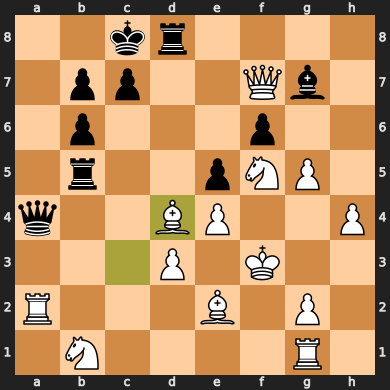

In [5]:
board = random_board()
board

In [6]:
print(stockfish(board, 10))

974


The Idea is that the Deep Learning Network will predict this score based on the positions of the pieces on the board.

# Creating the dataset

Now we need to convert the board representation to something meaningful.
A 3d matrix of sizes **8 x 8 x 14** where 8x8 repersents the board and the 14 represents the 7 different pieces 

In [7]:
squares_index = {
  'a': 0,
  'b': 1,
  'c': 2,
  'd': 3,
  'e': 4,
  'f': 5,
  'g': 6,
  'h': 7
}

# example: h3 -> 17
def square_to_index(square):
  letter = chess.square_name(square)
  return 8 - int(letter[1]), squares_index[letter[0]]

def split_dims(board):
  # this is the 3d matrix
  board3d = numpy.zeros((14, 8, 8), dtype=numpy.int8)

  # here we add the pieces's view on the matrix
  for piece in chess.PIECE_TYPES:
    for square in board.pieces(piece, chess.WHITE):
      idx = numpy.unravel_index(square, (8, 8))
      board3d[piece - 1][7 - idx[0]][idx[1]] = 1
    for square in board.pieces(piece, chess.BLACK):
      idx = numpy.unravel_index(square, (8, 8))
      board3d[piece + 5][7 - idx[0]][idx[1]] = 1

  # add attacks and valid moves too
  # so the network knows what is being attacked
  aux = board.turn
  board.turn = chess.WHITE
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[12][i][j] = 1
  board.turn = chess.BLACK
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[13][i][j] = 1
  board.turn = aux
  
  return board3d

In [76]:
print(split_dims(board)[13])
print(board)
# index 0 - white pawns
# index 1 - white knights
# index 2 - white bishops
# index 3 - white rooks
# index 4 - white queen
# index 5 - white knight
# index 6 - black pawns
# index 7 - black knights
# index 8 - black bishops
# index 9 - black rooks
# index 10 - black queen
# index 11 - black knight
# index 12 - possible white moves
# index 13 - possible black moves

[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . P .
P P P P P P . P
R N B Q K B N R


Now, all we have to do is call **random_board()** to create random boards, **stockfish()** to get a score for how good each board is for white.

Then we convert each board to a 3d matrix using **split_dims()**, now creating the dataset is easy!

# TensorFlow!

In [8]:
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers


def build_model(conv_size, conv_depth):
  board3d = layers.Input(shape=(14, 8, 8))

  # adding the convolutional layers
  x = board3d
  for _ in range(conv_depth):
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', activation='relu')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(64, 'relu')(x)
  x = layers.Dense(1, 'sigmoid')(x)

  return models.Model(inputs=board3d, outputs=x)

C:\Users\kylia\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Skip connections (residual network) will likely improve the model for deeper connections. If you want to test the residual model, check the code below.

In [9]:
def build_model_residual(conv_size, conv_depth):
  board3d = layers.Input(shape=(14, 8, 8))

  # adding the convolutional layers
  x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(board3d)
  for _ in range(conv_depth):
    previous = x
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, previous])
    x = layers.Activation('relu')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(1, 'sigmoid')(x)

  return models.Model(inputs=board3d, outputs=x)

In [10]:
model = build_model(32, 4)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 conv2d (Conv2D)             (None, 14, 8, 32)         2336      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 flatten (Flatten)           (None, 3584)              0         
                                                                 
 dense (Dense)               (None, 64)                22944

# It's training time!

In [22]:
import tensorflow.keras.callbacks as callbacks

dataset = {'b': [], 'v': []}

for i in range(1000):
	print("Generating board " + str(i))
	# Generate a random board
	board = random_board()
	# Get the stockfish score
	score = stockfish(board, 10)
	if (score == None):
		print("Got None score value on board " + str(i))
	else:
		# Add the board matrix and associated score to the dataset
		dataset['b'].append(split_dims(board))
		dataset['v'].append(score)

#print(type(dataset['v']))
dataset['b'] = numpy.asarray(dataset['b'])
dataset['v'] = numpy.asarray(dataset['v'])
#print(type(dataset['v']))

def get_dataset():
	#container = numpy.load('dataset.npz')
	b, v = dataset['b'], dataset['v']
	print(b, v)
	v = numpy.asarray(v / abs(v).max() / 2 + 0.5, dtype=numpy.float32) # normalization (0 - 1)
	return b, v

x_train, y_train = get_dataset()
x_train.transpose()
print(x_train.shape)
print(y_train.shape)

Generating board 0
Generating board 1
Generating board 2
Generating board 3
Generating board 4
Generating board 5
Generating board 6
Got None score value on board 6
Generating board 7
Generating board 8
Generating board 9
Got None score value on board 9
Generating board 10
Generating board 11
Generating board 12
Generating board 13
Generating board 14
Got None score value on board 14
Generating board 15
Generating board 16
Generating board 17
Generating board 18
Got None score value on board 18
Generating board 19
Generating board 20
Generating board 21
Generating board 22
Generating board 23
Generating board 24
Generating board 25
Generating board 26
Generating board 27
Generating board 28
Generating board 29
Generating board 30
Generating board 31
Got None score value on board 31
Generating board 32
Generating board 33
Generating board 34
Generating board 35
Generating board 36
Generating board 37
Generating board 38
Generating board 39
Generating board 40
Generating board 41
Generat

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint
model.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error')
model.summary()
checkpoint_filepath = '/tmp/checkpoint/'
model_checkpointing_callback = ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_best_only= True,
)
model.fit(x_train, y_train,
          batch_size=2048,
          epochs=100,
          verbose=1,
          validation_split=0.1,
          callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
                     callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-4),model_checkpointing_callback])

model.save('models/model_885boards_100epochs.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 conv2d (Conv2D)             (None, 14, 8, 32)         2336      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 flatten (Flatten)           (None, 3584)              0         
                                                                 
 dense (Dense)               (None, 64)                229440

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.0142INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


1/1 [==============================] - 4s 4s/step - loss: 0.0142 - val_loss: 0.0596 - lr: 5.0000e-04
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.0115INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


1/1 [==============================] - 1s 1s/step - loss: 0.0115 - val_loss: 0.0561 - lr: 5.0000e-04
Epoch 3/100
1/1 [==============================] - 0s 99ms/step - loss: 0.0142 - val_loss: 0.0601 - lr: 5.0000e-04
Epoch 4/100
1/1 [==============================] - 0s 94ms/step - loss: 0.0087 - val_loss: 0.0656 - lr: 5.0000e-04
Epoch 5/100
1/1 [==============================] - 0s 89ms/step - loss: 0.0107 - val_loss: 0.0580 - lr: 5.0000e-04
Epoch 6/100
1/1 [==============================] - ETA: 0s - loss: 0.0064INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


1/1 [==============================] - 2s 2s/step - loss: 0.0064 - val_loss: 0.0552 - lr: 5.0000e-04
Epoch 7/100
1/1 [==============================] - ETA: 0s - loss: 0.0073INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


1/1 [==============================] - 2s 2s/step - loss: 0.0073 - val_loss: 0.0551 - lr: 5.0000e-04
Epoch 8/100
1/1 [==============================] - 0s 177ms/step - loss: 0.0067 - val_loss: 0.0558 - lr: 5.0000e-04
Epoch 9/100
1/1 [==============================] - 0s 187ms/step - loss: 0.0042 - val_loss: 0.0595 - lr: 5.0000e-04
Epoch 10/100
1/1 [==============================] - 0s 166ms/step - loss: 0.0046 - val_loss: 0.0601 - lr: 5.0000e-04
Epoch 11/100
1/1 [==============================] - 0s 155ms/step - loss: 0.0043 - val_loss: 0.0565 - lr: 5.0000e-04
Epoch 12/100
1/1 [==============================] - 0s 151ms/step - loss: 0.0025 - val_loss: 0.0553 - lr: 5.0000e-04
Epoch 13/100
1/1 [==============================] - 0s 146ms/step - loss: 0.0029 - val_loss: 0.0554 - lr: 5.0000e-04
Epoch 14/100
1/1 [==============================] - 0s 175ms/step - loss: 0.0028 - val_loss: 0.0560 - lr: 5.0000e-04
Epoch 15/100
1/1 [==============================] - 0s 144ms/step - loss: 0.0014 -

c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Playing with the AI

In [30]:
from tensorflow.keras import models
model = models.load_model('model.h5')

In [35]:
# used for the minimax algorithm
def minimax_eval(board):
  board3d = split_dims(board)
  board3d = numpy.expand_dims(board3d, 0)
  return model(board3d)[0][0]


def minimax(board, depth, alpha, beta, maximizing_player):
  if depth == 0 or board.is_game_over():
    return minimax_eval(board)
  
  if maximizing_player:
    max_eval = -numpy.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, False)
      board.pop()
      max_eval = max(max_eval, eval)
      alpha = max(alpha, eval)
      if beta <= alpha:
        break
    return max_eval
  else:
    min_eval = numpy.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, True)
      board.pop()
      min_eval = min(min_eval, eval)
      beta = min(beta, eval)
      if beta <= alpha:
        break
    return min_eval


# this is the actual function that gets the move from the neural network
def get_ai_move(board, depth):
  max_move = None
  max_eval = -numpy.inf

  for move in board.legal_moves:
    board.push(move)
    eval = minimax(board, depth - 1, -numpy.inf, numpy.inf, False)
    board.pop()
    if eval > max_eval:
      max_eval = eval
      max_move = move
  
  return max_move

In [37]:
# Testing code AI(white) vs Stockfish(black)
board = chess.Board()
from IPython.display import clear_output

with chess.engine.SimpleEngine.popen_uci('stockfish.exe') as engine:
    while True:
        clear_output(wait=True)
        move = get_ai_move(board, 1)
        board.push(move)
        print(f'\n{board}')
        if board.is_game_over():
            print('game_over')
            break
        move = engine.analyse(board, chess.engine.Limit(time=0.1), info=chess.engine.INFO_PV)['pv'][0]
        board.push(move)
        print(f'\n{board}')
        if board.is_game_over():
            print('game_over')
            break


r n . . k . n r
p p . . . p p p
. . p . . . . .
b B . . . . . .
. . . q . . . .
. . . . . p P b
P P P . . . R P
R N B . . K . .

r n . . k . n r
p p . . . p p p
. . p . . . . .
b B . . . . . .
. . . q . . . .
. . . . . p P .
P P P . . . b P
R N B . . K . .
game_over


In [39]:
# Move by move testing code AI(white) vs Stockfish(black)
board = chess.Board()

with chess.engine.SimpleEngine.popen_uci('stockfish.exe') as engine:
    while True:
        move = get_ai_move(board, 1)
        board.push(move)
        print(f'\n{board}')
        if board.is_game_over():
            print('game_over')
            break
        move = engine.analyse(board, chess.engine.Limit(time=1), info=chess.engine.INFO_PV)['pv'][0]
        board.push(move)
        print(f'\n{board}')
        if board.is_game_over():
            print('game_over')
            break


r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . P .
P P P P P P . P
R N B Q K B N R

r n b q k b n r
p p p . p p p p
. . . . . . . .
. . . p . . . .
. . . . . . . .
. . . . . . P .
P P P P P P . P
R N B Q K B N R

r n b q k b n r
p p p . p p p p
. . . . . . . .
. . . p . . . .
. . . . . . . .
. . . . . N P .
P P P P P P . P
R N B Q K B . R

r n b q k b n r
p p p . p p . p
. . . . . . p .
. . . p . . . .
. . . . . . . .
. . . . . N P .
P P P P P P . P
R N B Q K B . R

r n b q k b n r
p p p . p p . p
. . . . . . p .
. . . p . . . .
. . . . . . . .
. . . . . N P .
P P P P P P . P
R N B Q K B R .

r n b q k b n r
p p . . p p . p
. . . . . . p .
. . p p . . . .
. . . . . . . .
. . . . . N P .
P P P P P P . P
R N B Q K B R .

r n b q k b n r
p p . . p p . p
. . . . . . p .
. . p p . . . .
. . . P . . . .
. . . . . N P .
P P P . P P . P
R N B Q K B R .

r n b q k b n r
p p . . p p . p
. . . . . . p .
. . . p . . . .
. . . p . . . .
. . . . . N P .


In [41]:
# Move by move testing code AI(white) vs Stockfish(black)
board = chess.Board()
from IPython.display import clear_output

with chess.engine.SimpleEngine.popen_uci('stockfish.exe') as engine:
    while True:
        clear_output(wait=True)
        move = get_ai_move(board, 1)
        board.push(move)
        print(move)
        print(f'\n{board}')
        if board.is_game_over():
            print('game_over')
            break
        input_var = input()
        move = chess.Move.from_uci(input_var)
        board.push(move)
        print(move)
        print(f'\n{board}')
        if board.is_game_over():
            print('game_over')
            break

g2g3

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . P .
P P P P P P . P
R N B Q K B N R


InvalidMoveError: expected uci string to be of length 4 or 5: ''